# California Housing Prices - Input Engineering and Data Cleaning

In this notebook, we will conduct input engineering and data cleaning on the California housing dataset. 

**Key notes:**

- Missing Values Inputation
- Removing Outliers
- Adjusting Skewness
- Adding New Attributes
- One Hot Encoding
- Standard Scaling
- Feature Importance

In [1]:
import pandas as pd
import numpy as np
from scipy.special import boxcox1p 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set_style("whitegrid")

In [3]:
data = pd.read_csv("housing.csv")

In [4]:
# Split into attributes and target
attributes = data.columns.values.tolist()
attributes.remove("median_house_value")

X = data[attributes]
y = data["median_house_value"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (20640, 9)
y shape: (20640,)


In [5]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14448, 9)
y_train shape: (14448,)
X_test shape: (6192, 9)
y_test shape: (6192,)


In [6]:
# Horizontally concatenate X_train and y_train 
train = pd.concat([X_train, y_train], axis=1)
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
1989,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
256,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
7887,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
4581,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
1993,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


In [7]:
# Horizontally concatenate X_test and y_test 
test = pd.concat([X_test, y_test], axis=1)
test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
14740,-117.05,32.58,22.0,2101.0,399.0,1551.0,371.0,4.1518,NEAR OCEAN,136900.0
10101,-117.97,33.92,32.0,2620.0,398.0,1296.0,429.0,5.7796,<1H OCEAN,241300.0
20566,-121.84,38.65,29.0,3167.0,548.0,1554.0,534.0,4.3487,INLAND,200700.0
2670,-115.60,33.20,37.0,709.0,187.0,390.0,142.0,2.4511,INLAND,72500.0
15709,-122.43,37.79,25.0,1637.0,394.0,649.0,379.0,5.0049,NEAR BAY,460000.0


In [8]:
# Save to csv files
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

## Missing Values Imputation

In [9]:
train.isnull().sum().to_frame("Count of Missing Values")

,Count of Missing Values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,137
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


There are 137 observations with missing values in the total_bedrooms column. Since the 137 obervations only take 137/14448 = 0.95% of the training dataset, we remove these observations before moving on. 

In [10]:
train = train[train["total_bedrooms"].notnull()]

In [11]:
train.isnull().sum().to_frame("Count of Missing Values")

,Count of Missing Values
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
ocean_proximity,0
median_house_value,0


Now there is no more missing values in the training dataset. 

## Removing Outliers

In [12]:
selected_attributes = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [13]:
def calculate_bounds(arr):
    percentile_25 = np.percentile(arr, 25)
    percentile_75 = np.percentile(arr, 75)
    iqr = percentile_75 - percentile_25
    lower_bound = percentile_25 - 1.5*iqr
    upper_bound = percentile_75 + 1.5*iqr
    return lower_bound, upper_bound

In [14]:
for col in selected_attributes:
    lower_bound, upper_bound = calculate_bounds(train[col])
    print(f"{col} \n Lower bound: {round(lower_bound, 2)} \n Upper bound: {round(upper_bound, 2)} \n")
    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

housing_median_age 
 Lower bound: -10.5 
 Upper bound: 65.5 

total_rooms 
 Lower bound: -1083.0 
 Upper bound: 5677.0 

total_bedrooms 
 Lower bound: -175.0 
 Upper bound: 1057.0 

population 
 Lower bound: -422.5 
 Upper bound: 2717.5 

households 
 Lower bound: -121.0 
 Upper bound: 911.0 

median_income 
 Lower bound: -0.72 
 Upper bound: 7.99 



In [15]:
def create_boxplots_in_subplots(data, selected_attributes):
    fig = plt.figure(figsize=(20, 20), dpi=300)
    for i in range(len(selected_attributes)):
        ax = fig.add_subplot(3, 3, i+1)
        ax = sns.boxplot(y=data[selected_attributes[i]])

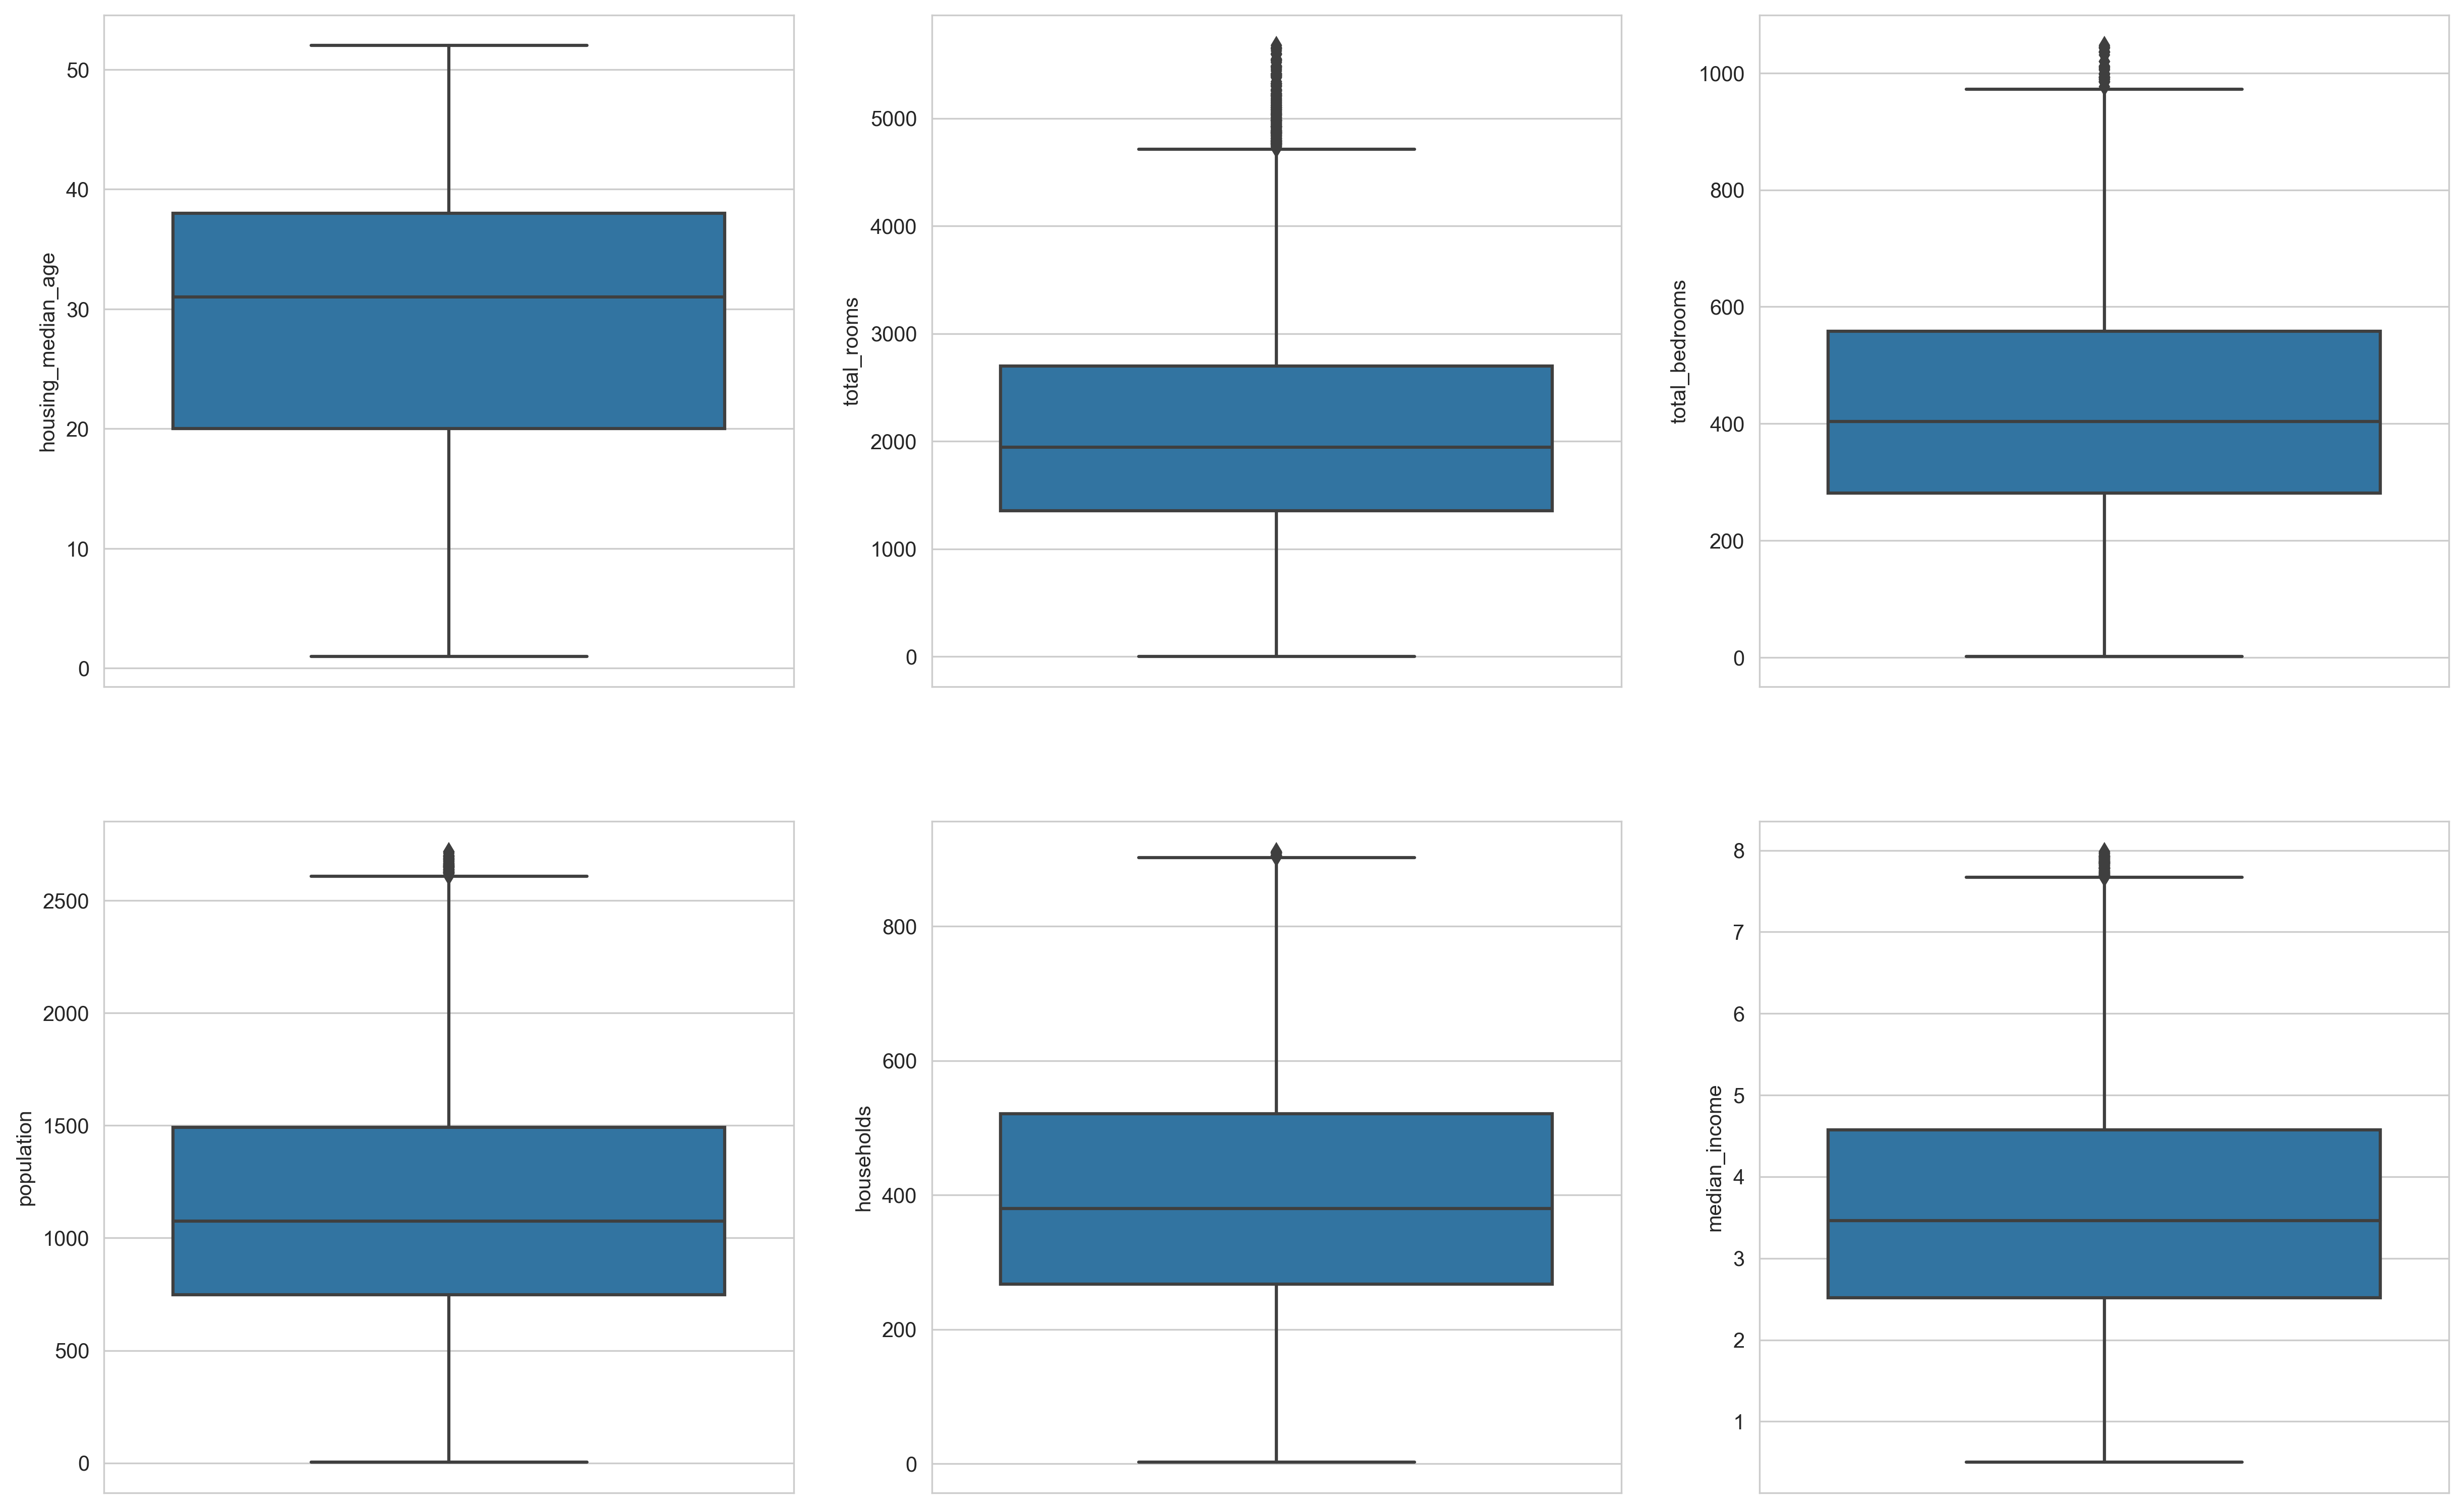

In [16]:
create_boxplots_in_subplots(train, selected_attributes)

Now all the outliers are removed.

## Adjusting Skewness

In [17]:
def get_skewness(train, selected_attributes):
    skewness_dict = {}
    for col in selected_attributes:
        skewness_dict[col] = round(train[col].skew(), 3)
    skewness_df = pd.DataFrame.from_dict(skewness_dict, orient='index').reset_index()
    skewness_df.columns = ["Column", "Skewness"]
    skewness_df.sort_values(by='Skewness', ascending=False, inplace=True)
    return skewness_df

In [18]:
skewness_df = get_skewness(train, selected_attributes)
skewness_df

,Column,Skewness
1,total_rooms,0.592
5,median_income,0.553
3,population,0.440
2,total_bedrooms,0.433
4,households,0.369
0,housing_median_age,-0.005


After trial and error, the following methods are used to adjust the skewness of each numeric attribute. 

In [19]:
def adjust_skewness(data):
    data_new = data.copy()
    data_new["total_rooms"] = data_new["total_rooms"].apply(lambda x: boxcox1p(x, 0.62))
    data_new["median_income"] = data_new["median_income"].apply(lambda x: boxcox1p(x, 0.24))
    data_new['population'] = data_new['population'].apply(lambda x: boxcox1p(x, 0.68))
    data_new["total_bedrooms"] = data_new["total_bedrooms"].apply(lambda x: boxcox1p(x, 0.68))
    data_new["households"] = data_new["households"].apply(lambda x: boxcox1p(x, 0.72))
    return data_new

In [20]:
train_new = adjust_skewness(train)

In [21]:
skewness_df = get_skewness(train_new, selected_attributes)
skewness_df

,Column,Skewness
5,median_income,0.003
2,total_bedrooms,0.002
3,population,-0.001
4,households,-0.003
0,housing_median_age,-0.005
1,total_rooms,-0.005


array([[<AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>]], dtype=object)

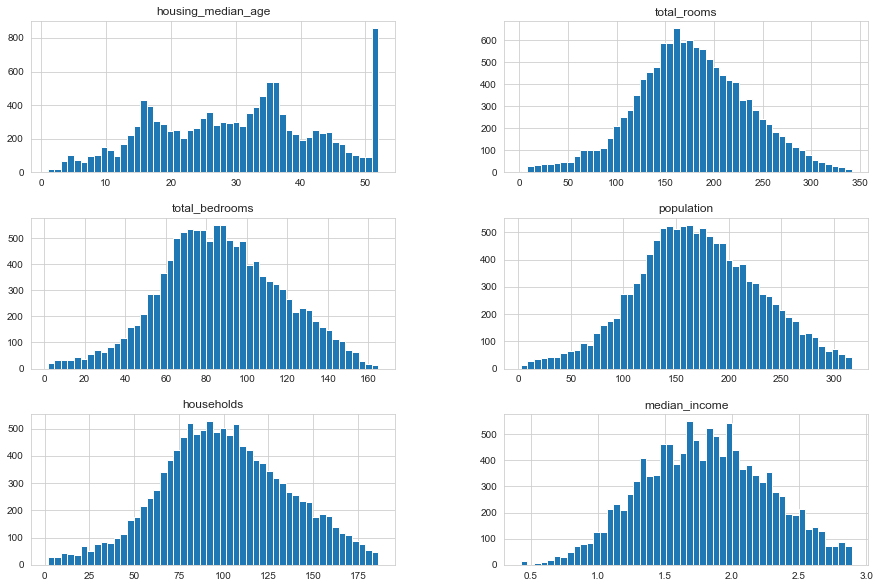

In [22]:
train_new[selected_attributes].hist(figsize=(15, 10), bins=50)

## Adding New Attributes

In [23]:
def add_new_attributes(data):
    data["longitude_over_latitude"] = data["longitude"] / data["latitude"]
    data["total_bedrooms_over_total_rooms"] = data["total_bedrooms"] / data["total_rooms"]
    data["population_over_total_rooms"] = data["population"] / data["total_rooms"]
    data["households_over_total_rooms"] = data["households"] / data["total_rooms"]
    data["population_over_total_bedrooms"] = data["population"] / data["total_bedrooms"]
    data["households_over_total_bedrooms"] = data["households"] / data["total_bedrooms"]
    data["population_over_households"] = data["population"] / data["households"]
    return data

In [24]:
train_new = add_new_attributes(train_new)

In [25]:
train_new.corr()["median_house_value"].sort_values(ascending=False)

median_house_value                 1.000000
median_income                      0.618019
total_rooms                        0.177359
housing_median_age                 0.128509
households_over_total_bedrooms     0.105288
households                         0.101132
total_bedrooms                     0.078464
longitude                         -0.035347
population                        -0.050571
households_over_total_rooms       -0.117489
latitude                          -0.159947
total_bedrooms_over_total_rooms   -0.184790
population_over_total_bedrooms    -0.196843
longitude_over_latitude           -0.218634
population_over_households        -0.255682
population_over_total_rooms       -0.298921
Name: median_house_value, dtype: float64

## One Hot Encoding

In [26]:
train_new["ocean_proximity"] = train_new["ocean_proximity"].str.lower()

In [27]:
train_new_encoded = pd.get_dummies(train_new, columns = ["ocean_proximity"])

In [28]:
train_new_encoded.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,longitude_over_latitude,total_bedrooms_over_total_rooms,population_over_total_rooms,households_over_total_rooms,population_over_total_bedrooms,households_over_total_bedrooms,population_over_households,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
1989,-119.79,36.73,52.0,28.622582,13.047911,51.397824,18.742414,1.246179,47500.0,-3.261367,0.455861,1.795709,0.654812,3.939161,1.436430,2.742327,0,1,0,0,0
256,-122.21,37.77,43.0,116.531168,74.244825,141.400515,78.480389,1.366500,100000.0,-3.235637,0.637124,1.213414,0.673471,1.904517,1.057049,1.801731,0,0,0,1,0
7887,-118.04,33.87,17.0,197.316800,84.563118,200.048377,95.778015,2.547188,285800.0,-3.485090,0.428565,1.013844,0.485402,2.365669,1.132622,2.088667,1,0,0,0,0
1993,-119.81,36.73,50.0,97.991743,51.582983,113.360478,54.187482,1.350214,59200.0,-3.261911,0.526401,1.156837,0.552980,2.197633,1.050491,2.092005,0,1,0,0,0
12992,-121.26,38.69,17.0,270.850551,117.443051,239.915656,131.700180,2.303914,137000.0,-3.134143,0.433608,0.885786,0.486247,2.042825,1.121396,1.821681,0,1,0,0,0


## Standard Scaling

In [29]:
X_train = train_new_encoded.loc[:, ~train_new_encoded.columns.isin(["median_house_value"])]
y_train = train_new_encoded.loc[:, train_new_encoded.columns.isin(["median_house_value"])]

In [30]:
# define standard scaler
scaler = StandardScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)

In [31]:
X_train_cleaned = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_cleaned.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,longitude_over_latitude,total_bedrooms_over_total_rooms,population_over_total_rooms,households_over_total_rooms,population_over_total_bedrooms,households_over_total_bedrooms,population_over_households,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,-0.084871,0.474066,1.800512,-2.567190,-2.486038,-2.015848,-2.283704,-1.188320,0.656160,-0.475042,3.134085,0.899590,4.139434,2.758734,2.669410,-0.869120,1.434042,-0.012817,-0.357656,-0.384728
1,-1.291109,0.953897,1.067450,-1.043790,-0.424393,-0.486000,-0.607216,-0.929175,0.828280,1.817482,0.891491,1.089351,-0.205013,-0.894181,0.165419,-0.869120,-0.697330,-0.012817,2.795983,-0.384728
2,0.787409,-0.845468,-1.050286,0.356175,-0.076783,0.510884,-0.121775,1.613756,-0.840429,-0.820261,0.122887,-0.823288,0.779657,-0.166518,0.929281,1.150589,-0.697330,-0.012817,-0.357656,-0.384728
3,-0.094840,0.474066,1.637609,-1.365066,-1.187841,-0.962619,-1.288973,-0.964252,0.652518,0.417118,0.673597,-0.136030,0.420860,-0.957317,0.938167,-0.869120,1.434042,-0.012817,-0.357656,-0.384728
4,-0.817586,1.378363,-1.050286,1.630469,1.030900,1.188540,0.886345,1.089799,1.507217,-0.756479,-0.370301,-0.814700,0.090309,-0.274604,0.218528,-0.869120,1.434042,-0.012817,-0.357656,-0.384728


## Feature Importance

In [32]:
# random forest for feature importance on a regression problem
def get_feature_importance(X_train_cleaned, y_train):
    # Define the model
    model = RandomForestRegressor(random_state=0)

    # Fit the model
    model.fit(X_train_cleaned, y_train)

    # Get feature importance
    importances = model.feature_importances_
    
    # Create arrays from feature names and feature importance
    feature_names = np.array(X_train_cleaned.columns)
    feature_importances = np.array(importances)

    # Create a DataFrame using a Dictionary
    fi_dict = {"feature_name": feature_names, "feature_importance": feature_importances}
    fi_df = pd.DataFrame(fi_dict)
    
    # Sort in decreasing order of feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    
    # Round the feature importance values
    fi_df["feature_importance"] = round(fi_df["feature_importance"], 3)
    
    return fi_df

In [33]:
fi_df = get_feature_importance(X_train_cleaned, y_train)
fi_df

<ipython-input-32-3586648ccd3a>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_cleaned, y_train)


,feature_name,feature_importance
7,median_income,0.397
16,ocean_proximity_inland,0.129
14,population_over_households,0.098
0,longitude,0.061
8,longitude_over_latitude,0.055
12,population_over_total_bedrooms,0.051
2,housing_median_age,0.049
10,population_over_total_rooms,0.036
1,latitude,0.027
9,total_bedrooms_over_total_rooms,0.020


In [34]:
def create_feature_importance_barplot(fi_df, model_name):
    # Create barplot of feature importance
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    ax = sns.barplot(data=fi_df, x="feature_importance", y="feature_name")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ".3f"), 
                    (p.get_width(), p.get_y()+p.get_height()), 
                    ha="left", va="center", xytext=(0, 10), textcoords="offset points")

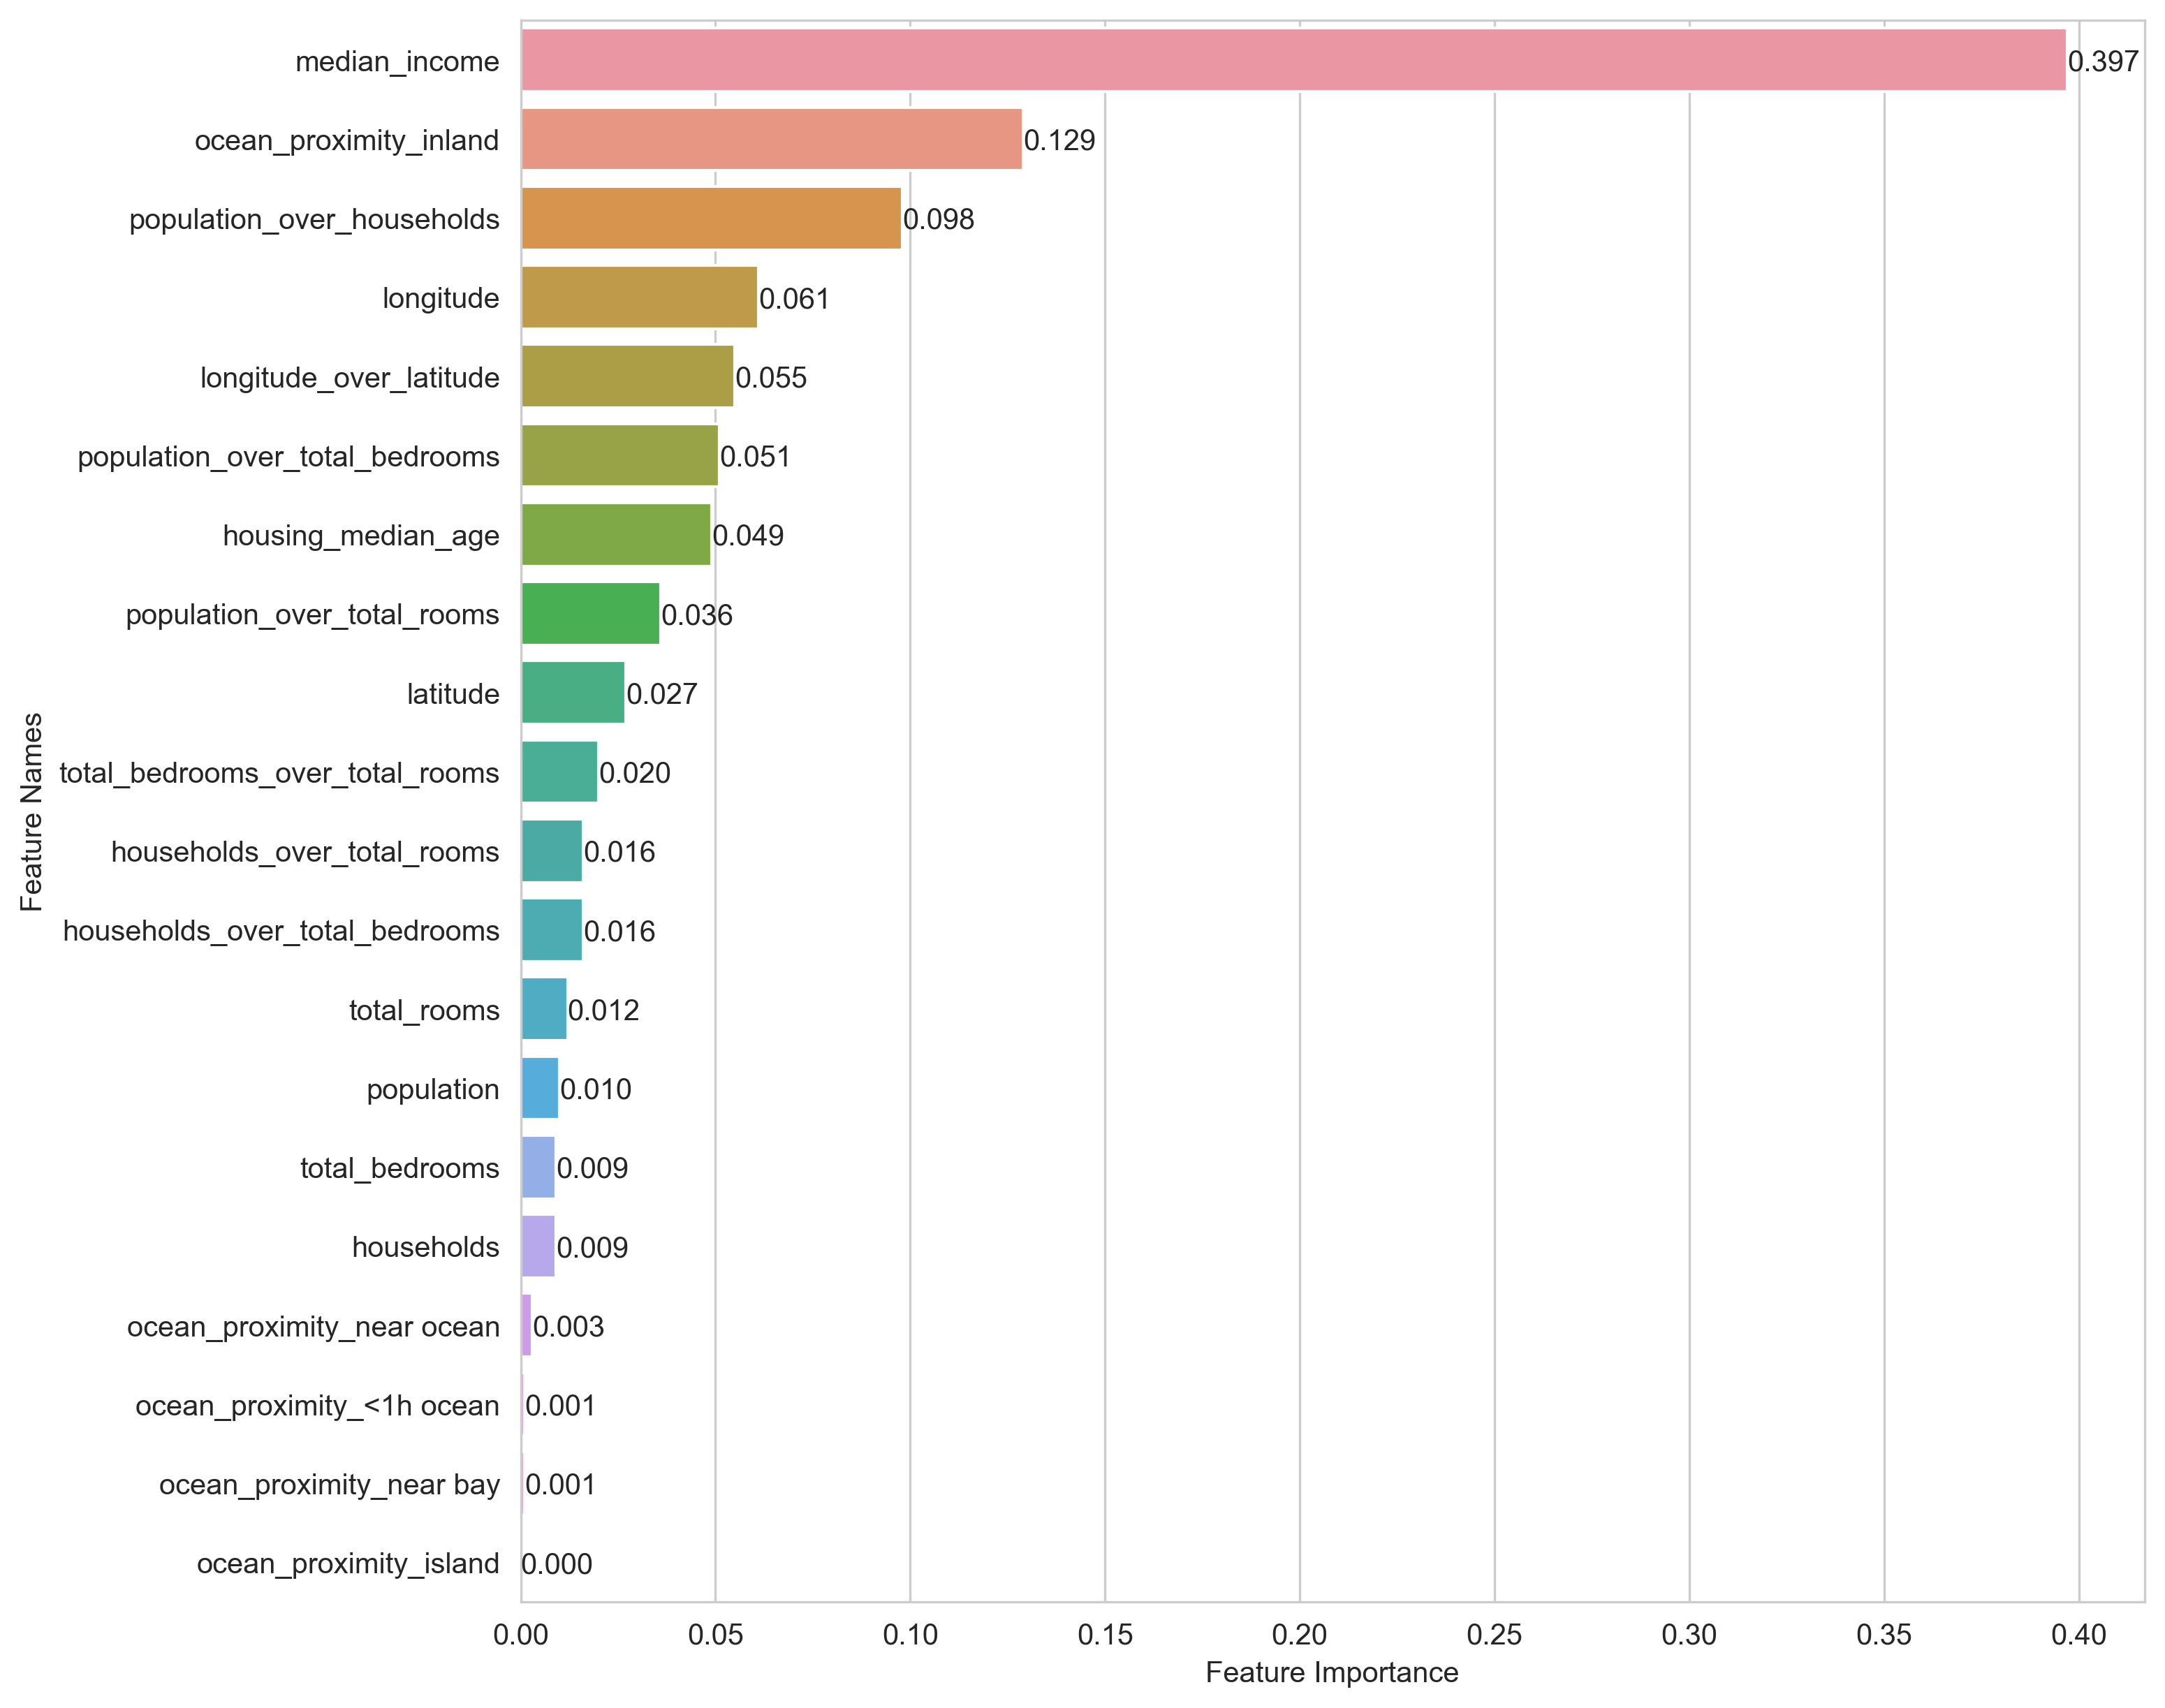

In [35]:
create_feature_importance_barplot(fi_df, model_name="Randome Forest")

In [36]:
def select_important_features(X_train_cleaned, y_train, feature_importance_threshold):
    # Define the model
    model = RandomForestRegressor(random_state=0)
    
    # Select important features
    print("Selecting important features ...")
    selection = SelectFromModel(model, threshold=feature_importance_threshold)

    # Fit the model
    selection.fit(X_train_cleaned, y_train)
    
    # Check which features are important
    selection_result = selection.get_support()
    
    # Check selected features 
    selected_features = X_train.columns[(selection_result)].tolist()
    
    print(f"{len(selected_features)} features have been selected.")
    print(selected_features)
    
    return selected_features

In [37]:
def test_performance(X_train_cleaned, y_train, feature_importance_threshold):
    # Define a dictionary to save to result 
    result = {}
    result["Threshold"] = feature_importance_threshold
    
    # Select important features
    selected_features = select_important_features(X_train_cleaned, y_train, feature_importance_threshold)
    result["Number of Features"] = len(selected_features)
    
    # Filter the dataset by only including the important features 
    X_train = X_train_cleaned[selected_features]
    
    # Define the model
    model = RandomForestRegressor(random_state=0)

    # Get the R2 value
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    r2 = np.sqrt(r2_scores).mean()
    result["R2"] = round(r2, 3)
        
    # Get the RMSE value 
    rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = np.sqrt(-rmse_scores).mean()
    result["RMSE"] = round(rmse, 3)
    
    return result

In [38]:
def evaluate_performance_of_feature_selection(X_train_cleaned, y_train, fi_df):
    results = []
    thresholds = sorted(list(set(fi_df["feature_importance"])))
    for feature_importance_threshold in thresholds:
        result = test_performance(X_train_cleaned, y_train, feature_importance_threshold)
        print(f"{result} \n")
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

In [39]:
results_df = evaluate_performance_of_feature_selection(X_train_cleaned, y_train, fi_df)
results_df

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


20 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_<1h ocean', 'ocean_proximity_inland', 'ocean_proximity_island', 'ocean_proximity_near bay', 'ocean_proximity_near ocean']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.0, 'Number of Features': 20, 'R2': 0.884, 'RMSE': 50089.35} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


18 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_<1h ocean', 'ocean_proximity_inland', 'ocean_proximity_near ocean']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.001, 'Number of Features': 18, 'R2': 0.884, 'RMSE': 50051.171} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


16 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.003, 'Number of Features': 16, 'R2': 0.884, 'RMSE': 50122.152} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


15 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.009, 'Number of Features': 15, 'R2': 0.884, 'RMSE': 49967.148} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


13 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.01, 'Number of Features': 13, 'R2': 0.885, 'RMSE': 49915.943} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


13 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'households_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.012, 'Number of Features': 13, 'R2': 0.885, 'RMSE': 49915.943} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


11 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'total_bedrooms_over_total_rooms', 'population_over_total_rooms', 'households_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.016, 'Number of Features': 11, 'R2': 0.885, 'RMSE': 49781.899} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


9 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.02, 'Number of Features': 9, 'R2': 0.887, 'RMSE': 49331.398} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


8 features have been selected.
['longitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.027, 'Number of Features': 8, 'R2': 0.885, 'RMSE': 49771.648} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


8 features have been selected.
['longitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.036, 'Number of Features': 8, 'R2': 0.885, 'RMSE': 49771.648} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


6 features have been selected.
['longitude', 'median_income', 'longitude_over_latitude', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.049, 'Number of Features': 6, 'R2': 0.877, 'RMSE': 51375.776} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


5 features have been selected.
['longitude', 'median_income', 'longitude_over_latitude', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.051, 'Number of Features': 5, 'R2': 0.878, 'RMSE': 51292.473} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


5 features have been selected.
['longitude', 'median_income', 'longitude_over_latitude', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.055, 'Number of Features': 5, 'R2': 0.878, 'RMSE': 51292.473} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


3 features have been selected.
['median_income', 'population_over_households', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.061, 'Number of Features': 3, 'R2': 0.746, 'RMSE': 71274.68} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


2 features have been selected.
['median_income', 'ocean_proximity_inland']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.098, 'Number of Features': 2, 'R2': 0.583, 'RMSE': 86945.775} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


1 features have been selected.
['median_income']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.129, 'Number of Features': 1, 'R2': 0.43, 'RMSE': 96597.667} 

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


1 features have been selected.
['median_income']


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation

{'Threshold': 0.397, 'Number of Features': 1, 'R2': 0.43, 'RMSE': 96597.667} 



,Threshold,Number of Features,R2,RMSE
0,0.000,20,0.884,50089.350
1,0.001,18,0.884,50051.171
2,0.003,16,0.884,50122.152
3,0.009,15,0.884,49967.148
4,0.010,13,0.885,49915.943
5,0.012,13,0.885,49915.943
6,0.016,11,0.885,49781.899
7,0.020,9,0.887,49331.398
8,0.027,8,0.885,49771.648
9,0.036,8,0.885,49771.648


In [58]:
def plot_scores_by_threshold(results_df):
    fig,axes = plt.subplots(2, 1, figsize=(8,8), dpi=300)
    sns.lineplot(x="Threshold", y="R2", data=results_df, ax=axes[0])
    sns.lineplot(x="Threshold", y="RMSE", data=results_df, ax=axes[1])
    for i in range(2):
        axes[i].set_xlabel("Threshold of feature importance")
    plt.show()

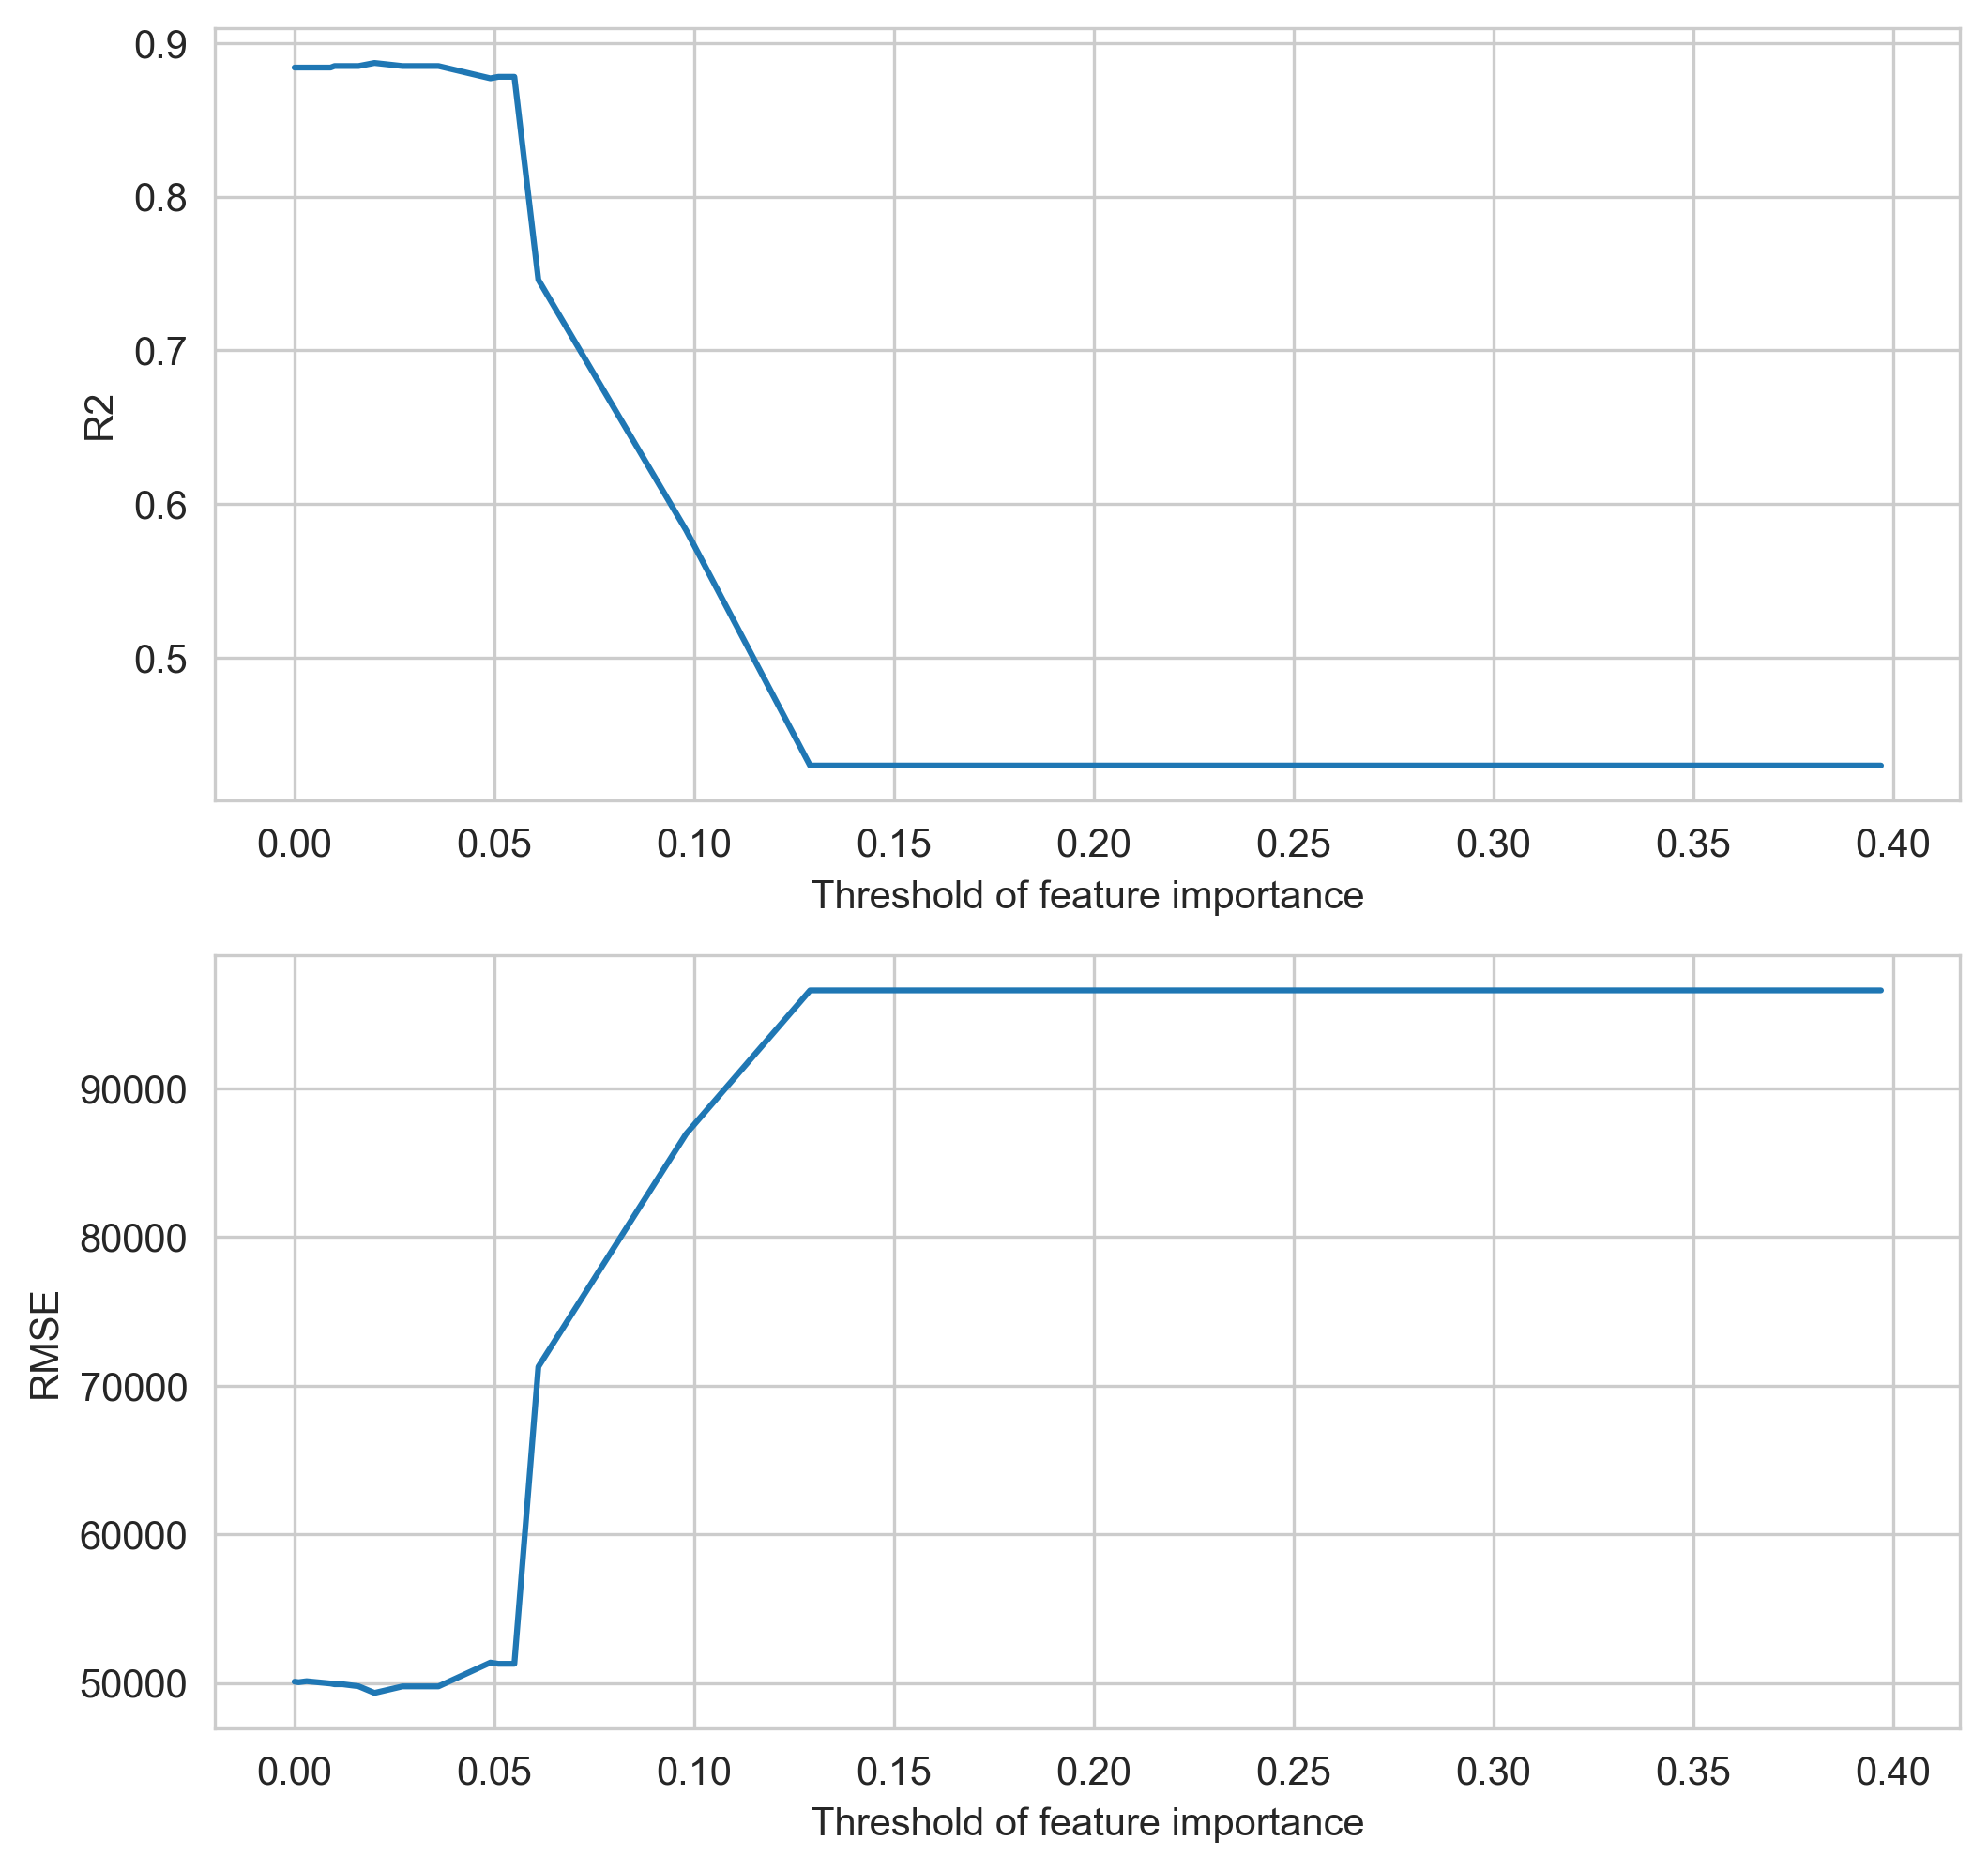

In [59]:
plot_scores_by_threshold(results_df)

The above plots show that the R2 value has a sudden decrease when the threshold of feature importance is around 0.06. Meanwhile the RMSE value has a sudden increase. To be more accurate, we find the threshold of feature importance that maximizes the R2 value and minimizes the RMSE value. 

In [51]:
results_df[results_df["R2"] == results_df["R2"].max()]

,Threshold,Number of Features,R2,RMSE
7,0.02,9,0.887,49331.398


In [49]:
results_df[results_df["RMSE"] == results_df["RMSE"].min()]

,Threshold,Number of Features,R2,RMSE
7,0.02,9,0.887,49331.398


It turns out when the threshold of feature importance is 0.02, the R2 value is maximized, and the RMSE value is minimized. There are 9 features selected. 

In [66]:
best_threshold = results_df[results_df["RMSE"] == results_df["RMSE"].min()]["Threshold"].values[0]

In [83]:
def remove_unimportant_features(X_train_cleaned, y_train, best_threshold):    
    # Define the model
    model = RandomForestRegressor(random_state=0)
    
    # Select important features
    print("Selecting important features ...")
    selection = SelectFromModel(model, threshold=best_threshold)

    # Fit the model
    selection.fit(X_train_cleaned, y_train)
    
    # Check which features are important
    selection_result = selection.get_support()
    
    # Check selected features 
    selected_features = X_train.columns[(selection_result)].tolist()
    
    print(f"{len(selected_features)} features have been selected.")
    print(selected_features)
    
    X_train_cleaned_selected = selection.transform(X_train_cleaned)
    
    X_train_cleaned_selected = pd.DataFrame(X_train_selected)
    X_train_cleaned_selected.columns = selected_features

    return X_train_cleaned_selected

In [84]:
X_train_cleaned_selected = remove_unimportant_features(X_train_cleaned, y_train, best_threshold)
X_train_cleaned_selected.head()

Selecting important features ...


/Users/zyzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:234: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


9 features have been selected.
['longitude', 'latitude', 'housing_median_age', 'median_income', 'longitude_over_latitude', 'population_over_total_rooms', 'population_over_total_bedrooms', 'population_over_households', 'ocean_proximity_inland']


,longitude,latitude,housing_median_age,median_income,longitude_over_latitude,population_over_total_rooms,population_over_total_bedrooms,population_over_households,ocean_proximity_inland
0,-0.084871,0.474066,1.800512,-1.188320,0.656160,3.134085,4.139434,2.669410,1.434042
1,-1.291109,0.953897,1.067450,-0.929175,0.828280,0.891491,-0.205013,0.165419,-0.697330
2,0.787409,-0.845468,-1.050286,1.613756,-0.840429,0.122887,0.779657,0.929281,-0.697330
3,-0.094840,0.474066,1.637609,-0.964252,0.652518,0.673597,0.420860,0.938167,1.434042
4,-0.817586,1.378363,-1.050286,1.089799,1.507217,-0.370301,0.090309,0.218528,1.434042


In [85]:
print(X_train_cleaned_selected.shape)
print(y_train.shape)

(12177, 9)
(12177, 1)


In [86]:
X_train_cleaned_selected.to_csv("X_train_cleaned_selected.csv", index=False)
y_train.to_csv("y_train.csv", index=False)